In [1]:
import gzip
import umap
import pandas as pd
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from IPython.display import clear_output
from tqdm import tqdm
from biomart import BiomartServer

2024-07-26 14:17:17.612589: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# with gzip.open('../data/GSE116222_Expression_matrix.txt.gz', 'rt') as f:
#     expr_matrix = pd.read_csv(f, sep='\t', index_col=0)

In [3]:
# expression_data = expr_matrix.T

# labels = expression_data.index.str.split('-').str[1].to_list()

# inflammation_labels = ['UC inflamed' if x.endswith('3') else 'UC non-inflamed' if x.endswith('2') else 'Healthy' for x in labels]
# inflammation_labels = pd.Series(inflammation_labels, index=expression_data.index, name='Inflammation')

In [ ]:
# server = BiomartServer("http://www.ensembl.org/biomart")
# mart = server.datasets['hsapiens_gene_ensembl']

# response = mart.search({
#     'filters': {
#         'biotype': 'protein_coding'
#     },
#     'attributes': [
#         'external_gene_name'
#     ]
# })

In [ ]:
# protein_coding_genes = [line.strip() for line in response.iter_lines(decode_unicode=True)]
# protein_coding_genes = set(protein_coding_genes)

In [ ]:
# # save the protein coding genes to a file
# with open('../data/protein_coding_genes.txt', 'w') as f:
#     f.write('\n'.join(protein_coding_genes))

In [16]:
# with open('../data/protein_coding_genes.txt', 'r') as f:
#     protein_coding_genes = f.read().splitlines()

In [17]:
# filtered_df = expression_data[[gene for gene in expression_data.columns if gene in protein_coding_genes]]

In [18]:
# # drop columns with zero variance
# filtered_df = filtered_df.loc[:, filtered_df.var() > 0]

In [41]:
# filtered_df.to_parquet('../data/filtered_expression_data.parquet')

In [2]:
filtered_df = pd.read_parquet('../data/filtered_expression_data.parquet')

In [3]:
inflammation_labels = pd.read_csv('../data/inflammation_labels.csv', index_col=0, header=0, names=['Inflammation']).squeeze()

In [4]:
scaled_data = filtered_df.values

In [5]:
def debug_print(selected_genes, model, loss):
    print(f'Genes: {selected_genes}, Loss: {loss.item()}')
    for name, param in model.named_parameters():
        print(f'Parameter name: {name}, Gradient: {param.grad}')

    print('------------------------------------------------------------------')
    print(f'Encoder weights: {model.encoder.weight}')
    print(f'Encoder biases: {model.encoder.bias}')
    print(f'Decoder weights: {model.decoder.weight}')
    print(f'Decoder biases: {model.decoder.bias}')

def plot_learning_curves(training_losses, validation_losses, other_losses=None):
    clear_output(wait=True)

    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    
    if other_losses:
        for name, loss in other_losses.items():
            plt.plot(loss, label=name)

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

class Autoencoder(nn.Module):
    def __init__(self, layer_dims):
        super(Autoencoder, self).__init__()
        encoder_layers = []
        for i in range(1, len(layer_dims)):
            encoder_layers.append(nn.Linear(layer_dims[i-1], layer_dims[i]))
            encoder_layers.append(nn.ReLU())
            
        self.encoder = nn.Sequential(*encoder_layers)
        
        decoder_layers = []
        for i in range(len(layer_dims) - 1, 0, -1):
            decoder_layers.append(nn.Linear(layer_dims[i], layer_dims[i-1]))
            decoder_layers.append(nn.ReLU())

        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        x = torch.relu(self.encoder(x))
        x = self.decoder(x)
        return x

# class Autoencoder(nn.Module):
#     def __init__(self, input_size, hidden_size, dropout_rate=0.2):
#         super(Autoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Linear(input_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate)
#         )
#         self.decoder = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size),
#             nn.ReLU(),
#             nn.Dropout(dropout_rate),
#             nn.Linear(hidden_size, input_size),
#             nn.ReLU()
#         )

#     def forward(self, x):
#         x = self.encoder(x)
#         x = self.decoder(x)
#         return x


# class Transformer(nn.Module):
#     def __init__(self, input_size, hidden_size, nhead, num_layers):
#         super(Transformer, self).__init__()
#         self.encoder = nn.TransformerEncoder(
#             nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_size),
#             num_layers=num_layers
#         )
#         self.decoder = nn.TransformerDecoder(
#             nn.TransformerDecoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_size),
#             num_layers=num_layers
#         )

#     def forward(self, x):
#         x = x.unsqueeze(0)  # Add a dimension for sequence length
#         x = self.encoder(x)
#         x = x.squeeze(0)  # Remove the sequence length dimension
#         x = self.decoder(x)
#         return x

In [10]:
# # Processing single sample at a time

# # Dataset
# no_samples = scaled_data.shape[0]
# no_genes = scaled_data.shape[1]

# scaled_data_toy = scaled_data[:no_samples, :no_genes]

# X_train, X_test = train_test_split(scaled_data_toy, test_size=0.2, random_state=23)

# X_train = torch.tensor(X_train, dtype=torch.float32)
# X_test = torch.tensor(X_test, dtype=torch.float32)

# # Hyperparameters
# input_size = X_train.shape[1]
# hidden_size = 124
# num_epochs = 10
# learning_rate = 0.001
# masking_value = 0

# # Create the autoencoder model
# model = Autoencoder(input_size, hidden_size)

# # Loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# training_losses = []
# validation_losses = []
# # Training loop
# for epoch in range(num_epochs):
#     epoch_losses = []
#     for sample in X_train:
#         # randomly select how many genes to mask from 1 to 90% of the genes
#         mask = sample != masking_value
#         if mask.sum() < 2:
#             continue

#         non_empty_indexes = torch.nonzero(mask).flatten()
#         no_of_genes_to_mask = np.random.randint(1, int(0.9 * len(non_empty_indexes)))
#         selected_genes = np.random.choice(non_empty_indexes, no_of_genes_to_mask, replace=False)

#         # Corrupt the input data by setting the selected gene to a special value
#         sample_corrupted = sample.clone()
#         sample_corrupted[selected_genes] = masking_value

#         # Forward pass
#         output = model(sample_corrupted)

#         # Compute loss only for the selected genes; put much more weight on genes with non-zero values
#         mask = sample[selected_genes] != masking_value
#         loss = criterion(output[selected_genes][mask], sample[selected_genes][mask])
        
#         epoch_losses.append(loss.item())

#         # Backward pass and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         # debug_print(selected_genes, model, loss)
#         # break
#         optimizer.step()

#     # break

#     # Compute the average loss for the epoch
#     epoch_loss = np.mean(epoch_losses)
#     training_losses.append(epoch_loss)

#     # Compute validation loss
#     with torch.no_grad():
#         val_losses = []
#         for sample in X_test:
#             mask = sample != masking_value
#             if mask.sum() < 2:
#                 continue

#             non_empty_indexes = torch.nonzero(mask).flatten()
#             no_of_genes_to_mask = np.random.randint(1, int(0.9 * len(non_empty_indexes)))
#             selected_genes = np.random.choice(non_empty_indexes, no_of_genes_to_mask, replace=False)

#             sample_corrupted = sample.clone()
#             sample_corrupted[selected_genes] = masking_value

#             output = model(sample_corrupted)
#             mask = sample[selected_genes] != masking_value
#             loss = criterion(output[selected_genes][mask], sample[selected_genes][mask])
#             val_losses.append(loss.item())
            
#         val_loss = np.mean(val_losses)

#     validation_losses.append(val_loss)

#     plot_learning_curves(training_losses, validation_losses)
#     print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss}, Validation loss: {val_loss}') 

In [6]:
# Dataset
no_samples = scaled_data.shape[0]
no_genes = scaled_data.shape[1]

scaled_data_toy = scaled_data[:no_samples, :no_genes]

X_train, X_test = train_test_split(scaled_data_toy, test_size=0.2, random_state=23)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Hyperparameters
input_size = X_train.shape[1]
layer_dims = [input_size, 1024]
num_epochs = 50
learning_rate = 0.001
masking_value = 0
batch_size = 32
min_genes_to_mask = 0.5
max_genes_to_mask = 0.8

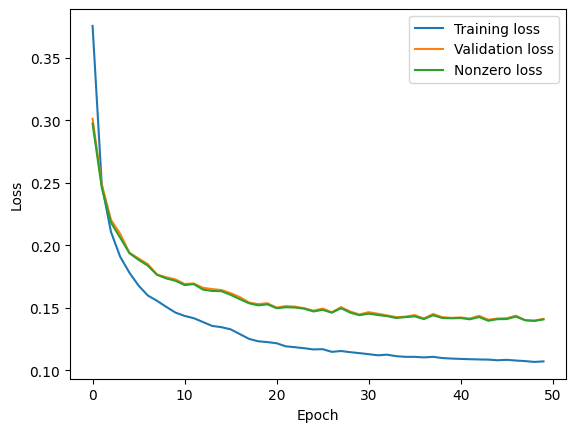

Epoch [49/50], Loss: 0.1071, Val selected loss: 0.1411, Val nonzero loss: 0.1407, Zero loss: 0.9518


In [10]:
# Batch processing

# Create the autoencoder model
model = Autoencoder(layer_dims)
# model = TransformerAutoencoder(input_size, hidden_size, nhead=1, num_layers=1)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders
train_loader = DataLoader(TensorDataset(X_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test), batch_size=batch_size, shuffle=False)

training_losses = []
validation_selected_losses = []
validation_nonzero_losses = []
validation_zero_losses = []
# Training loop
for epoch in range(num_epochs):
    epoch_losses = []
    for batch, in train_loader:
        batch_corrupted = batch.clone()
        for i in range(batch.size(0)):
            # Corrupt the input data by setting the selected gene to a special value
            mask = batch[i] != masking_value
            non_empty_indexes = torch.nonzero(mask).flatten()
            no_of_genes_to_mask = torch.randint(int(min_genes_to_mask * len(non_empty_indexes)), int(max_genes_to_mask * len(non_empty_indexes)), (1,))
            selected_genes = non_empty_indexes[torch.randint(len(non_empty_indexes), (no_of_genes_to_mask,))]

            batch_corrupted[i, selected_genes] = masking_value

        # Forward pass
        output = model(batch_corrupted)

        # Compute loss only for the selected genes
        loss = criterion(output[batch != batch_corrupted], batch[batch != batch_corrupted])

        # # Compute the loss for all non-zero genes in the batch
        # mask = batch != masking_value
        # loss = criterion(output[mask], batch[mask])
        
        epoch_losses.append(loss.item())

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute the average loss for the epoch
    epoch_loss = np.mean(epoch_losses)
    training_losses.append(epoch_loss)

    # Compute validation loss
    with torch.no_grad():
        val_selected_losses = []
        val_nonzero_losses = []
        zero_losses = []
        for batch, in test_loader:
            batch_corrupted = batch.clone()
            for i in range(batch.size(0)):
                mask = batch[i] != masking_value
                non_empty_indexes = torch.nonzero(mask).flatten()
                no_of_genes_to_mask = torch.randint(int(min_genes_to_mask * len(non_empty_indexes)), int(max_genes_to_mask * len(non_empty_indexes)), (1,))
                selected_genes = non_empty_indexes[torch.randint(len(non_empty_indexes), (no_of_genes_to_mask,))]

                batch_corrupted[i, selected_genes] = masking_value

            output = model(batch_corrupted)
            loss = criterion(output[batch != batch_corrupted], batch[batch != batch_corrupted])
            val_selected_losses.append(loss.item())

            # compute loss for all the genes with zero values
            loss = criterion(output[batch == masking_value], batch[batch == masking_value])
            zero_losses.append(loss.item())

            # Compute the loss for all non-zero genes in the batch
            mask = batch != masking_value
            loss = criterion(output[mask], batch[mask])
            val_nonzero_losses.append(loss.item())
            
        val_selected_loss = np.mean(val_selected_losses)
        val_nonzero_loss = np.mean(val_nonzero_losses)
        zero_loss = np.mean(zero_losses)

    validation_selected_losses.append(val_selected_loss)
    validation_nonzero_losses.append(val_nonzero_loss)
    validation_zero_losses.append(zero_loss)

    plot_learning_curves(training_losses, validation_selected_losses, {'Nonzero loss': validation_nonzero_losses})
    print(f'Epoch [{epoch}/{num_epochs}], Loss: {epoch_loss:.4f}, Val selected loss: {val_selected_loss:.4f}, Val nonzero loss: {val_nonzero_loss:.4f}, Zero loss: {zero_loss:.4f}') 

In [12]:
# # save the model
# torch.save(model.state_dict(), '../models/autoencoder_1024.pth')

In [7]:
# load the model
input_size = filtered_df.shape[1]
layer_dims = [input_size, 1024]

criterion = nn.MSELoss()
model = Autoencoder(layer_dims)
model.load_state_dict(torch.load('../models/autoencoder_1024.pth'))

<All keys matched successfully>

In [8]:
model = model.eval()

In [ ]:
# check the loss of a model that predicts mean value for all the genes; compute the means for each gene separately and use only non-zero values
zero_losses = []
with torch.no_grad():
    means = pd.DataFrame(X_train).replace(masking_value, np.nan).mean(axis=0, skipna=True).to_numpy()
    for sample in X_test:
        mask = sample != masking_value
        loss = criterion(torch.tensor(means[mask], dtype=torch.float32), sample[mask])
        zero_losses.append(loss.item())

nans = np.isnan(zero_losses)
zero_losses = np.array(zero_losses)[~nans]
print(f'Mean zero loss: {np.mean(zero_losses)}')

In [27]:
# Predicting the expression of a specific gene
def predict_gene_expression(data):
    with torch.no_grad():
        output = model(data)
    
    return output

perturbation = 0

# Select a random sample
sample_id = np.random.randint(X_test.shape[0])
test_sample = X_test[sample_id].reshape(1, -1).clone()

# Select a random, non-zero gene
mask = test_sample != masking_value
non_empty_indexes = torch.nonzero(mask[0]).flatten()
gene_index = np.random.choice(non_empty_indexes)

print('Original:', test_sample)
print('Original gene expression:', test_sample[0, gene_index])

test_sample[0, gene_index] = perturbation
print('Perturbed:', test_sample)
print('Perturbed gene expression:', test_sample[0, gene_index])

predicted_expression = predict_gene_expression(test_sample)
print('Predicted:', predicted_expression.detach().numpy())
print('Predicted gene expression:', predicted_expression[0, gene_index])

# compute the loss for all non-zero genes in the sample
mask = test_sample != masking_value
non_empty_indexes = torch.nonzero(mask).flatten()
selected_genes = non_empty_indexes[non_empty_indexes != gene_index]

with torch.no_grad():
    loss = criterion(predicted_expression[0, selected_genes], test_sample[0, selected_genes])

print('Loss:', loss.item())

Original: tensor([[0.0000, 0.0000, 0.0000,  ..., 1.4796, 0.0000, 2.6785]])
Original gene expression: tensor(2.0518)
Perturbed: tensor([[0.0000, 0.0000, 0.0000,  ..., 1.4796, 0.0000, 2.6785]])
Perturbed gene expression: tensor(0.)
Predicted: [[1.455495  1.582941  1.2663767 ... 3.4844809 1.7397258 4.859814 ]]
Predicted gene expression: tensor(1.6869)
Loss: 1.1767053604125977


In [28]:
inflammation_labels_int = inflammation_labels.replace('Healthy', 0).replace('UC non-inflamed', 1).replace('UC inflamed', 2)

reducer = umap.UMAP()
reducer = reducer.fit(scaled_data)

In [29]:
data_embedding = reducer.transform(scaled_data)

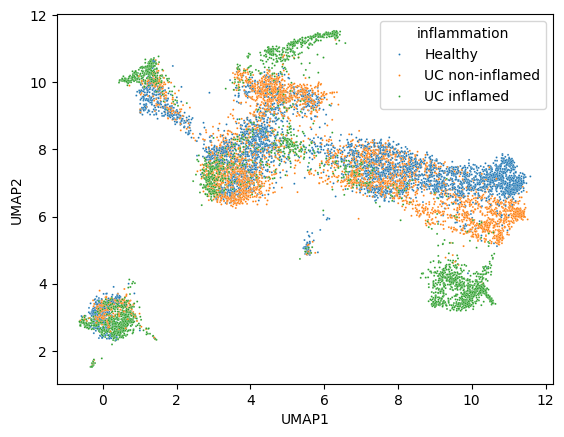

In [30]:
import seaborn as sns

# plot the data
plot_data = pd.concat([pd.DataFrame(data_embedding, index=filtered_df.index, columns=['UMAP1', 'UMAP2']), pd.Series(inflammation_labels).rename('inflammation')], axis=1)

sns.scatterplot(data=plot_data, x='UMAP1', y='UMAP2', hue='inflammation', s=2);

In [11]:
# predict the expression of all genes for all samples in filtered_df
predicted_data = predict_gene_expression(torch.tensor(filtered_df.values, dtype=torch.float32)).detach().numpy()

In [13]:
pd.DataFrame(predicted_data, index=filtered_df.index, columns=filtered_df.columns).to_parquet('../data/predicted_expression_data.parquet')

In [14]:
predicted_reducer = umap.UMAP()
predicted_reducer = predicted_reducer.fit(predicted_data)

In [55]:
# import pickle

# with open('../models/umap_reducer.pkl', 'wb') as f:
#     pickle.dump(predicted_reducer, f)

In [37]:
import pickle

with open('../models/umap_reducer.pkl', 'rb') as f:
    predicted_reducer = pickle.load(f)

In [15]:
predicted_data_embedding = predicted_reducer.transform(predicted_data)

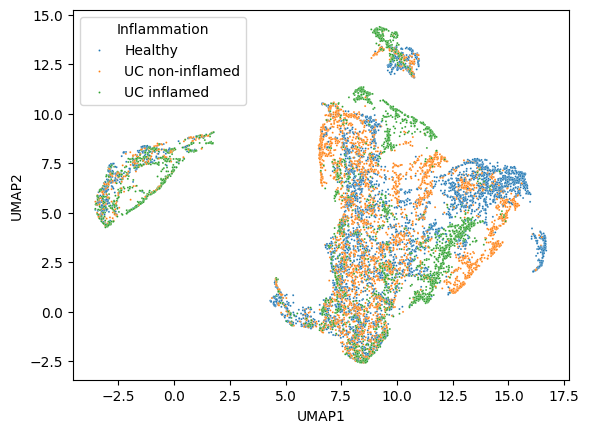

In [26]:
plot_data = pd.concat([pd.DataFrame(predicted_data_embedding, index=filtered_df.index, columns=['UMAP1', 'UMAP2']), pd.Series(inflammation_labels).rename('Inflammation')], axis=1)

sns.scatterplot(data=plot_data, x='UMAP1', y='UMAP2', hue='Inflammation', s=2);

In [10]:
# Predicting the expression of a specific gene
def predict_gene_expression(data):
    with torch.no_grad():
        output = model(data)
    
    return output

In [35]:
# Predicting the expression of a specific gene
def predict_gene_expression(data):
    with torch.no_grad():
        output = model(data)
    
    return output


def predict_expression(cell):
    # create a square matrix with the same cell repeated multiple times, mask the diagonal, predict the expression of the diagonal, collapse the diagonal to a vector
    cell_copy = cell.clone()
    cell_copy = cell_copy.repeat(cell.shape[1], 1)
    mask = torch.eye(cell.shape[1]) == 0
    cell_copy[mask] = 0

    predicted_expression = predict_gene_expression(cell_copy)

    predicted_expression = torch.diag(predicted_expression).reshape(1, -1)

    return predicted_expression    


max_iterations = 20
step_frac = 0.1
target_expression = 0

# select a gene
gene_index = np.random.randint(filtered_df.shape[1])
gene_name = filtered_df.columns[gene_index]
print(f'Gene name: {gene_name}')

# select a sample from filtered_df
sample_id = np.random.choice(filtered_df.index[inflammation_labels == 'Healthy'])
test_sample = torch.tensor(filtered_df.loc[sample_id].values, dtype=torch.float32).reshape(1, -1)
perturbed_sample = test_sample.clone()

gene_expression = perturbed_sample[0, gene_index]
step = step_frac * (target_expression - gene_expression)

cell_states = []
predicted_expression = predict_expression(perturbed_sample)
cell_states.append(predicted_expression)
for i in tqdm(range(max_iterations)):
    gene_expression += step

    if np.isclose(gene_expression, target_expression, atol=1e-5):
        step = 0

    predicted_expression[0, gene_index] = gene_expression

    predicted_expression = predict_expression(predicted_expression)

    # break if previous expression is very similar to any of the previous expressions
    if step == 0 and torch.allclose(predicted_expression, cell_states[-1], atol=0.1):
        break

    cell_states.append(predicted_expression)

cell_states = torch.cat(cell_states, dim=0)

Gene name: ADAM15


100%|██████████| 20/20 [04:56<00:00, 14.83s/it]


In [36]:
cell_states_embedding = predicted_reducer.transform(cell_states.numpy())

NameError: name 'predicted_reducer' is not defined

In [38]:
cell_states_df = pd.DataFrame(cell_states.detach().numpy(), columns=filtered_df.columns)

In [39]:
ranking = (cell_states_df.iloc[0] - cell_states_df.iloc[-1]).sort_values(ascending=False)

ranking

HBA2        0.632295
HBB         0.625848
DEFA5       0.484550
HLA-DQB2    0.482718
DENND2C     0.424163
              ...   
BEST4      -0.663987
CXCL5      -0.696512
DEFB4A     -0.725139
MZB1       -0.825431
ADAM15     -0.857856
Length: 15421, dtype: float32

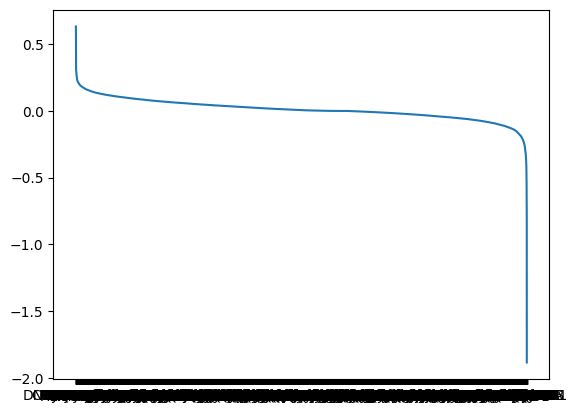

In [42]:
#plot the ranking
plt.plot(ranking);

In [32]:
ranking

NameError: name 'ranking' is not defined

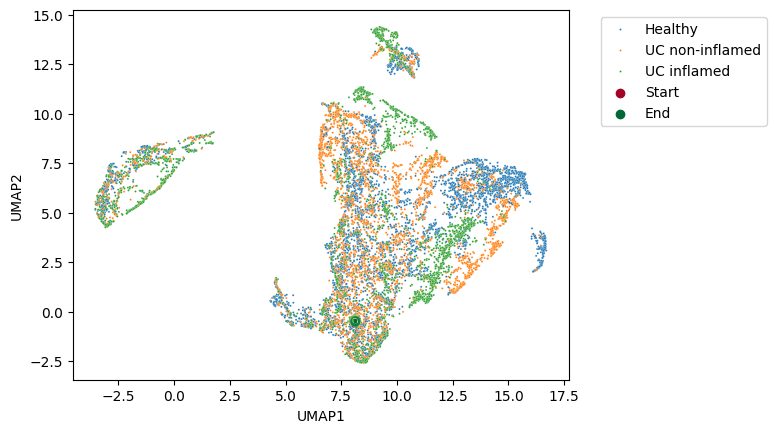

In [28]:
import seaborn as sns

sns.scatterplot(data=plot_data, x='UMAP1', y='UMAP2', hue='Inflammation', s=2);

# plot a path following the cell states, coloring each edge and state from red to green, but don't add the colors to the legend
colors = np.linspace(0, 1, cell_states_embedding.shape[0])
plt.scatter(cell_states_embedding[0, 0], cell_states_embedding[0, 1], color=plt.cm.RdYlGn(colors[0]), label='Start')
plt.scatter(cell_states_embedding[-1, 0], cell_states_embedding[-1, 1], color=plt.cm.RdYlGn(colors[-1]), label='End')
plt.scatter(cell_states_embedding[1:-1, 0], cell_states_embedding[1:-1, 1], color=plt.cm.RdYlGn(colors[1:-1]))

# plot lines connecting the cell states, coloring each edge from red to green
for i in range(1, cell_states_embedding.shape[0]):
    plt.plot([cell_states_embedding[i-1, 0], cell_states_embedding[i, 0]], [cell_states_embedding[i-1, 1], cell_states_embedding[i, 1]], color=plt.cm.RdYlGn(colors[i]), linewidth=2)

# move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left');

# zoom in on the path
# plt.xlim(6, 6.75)
# plt.ylim(1, 2);

# save the plot to a file
# plt.savefig('path_zoom.png', dpi=300, bbox_inches='tight')

In [27]:
# predict the expression for all samples in the test set and embed them
predicted_expressions = []
for sample in X_test:
    predicted_expression = predict_gene_expression(sample.reshape(1, -1))
    predicted_expressions.append(predicted_expression.numpy())

In [28]:
predicted_expressions = np.array(predicted_expressions).squeeze()
predicted_embeddings = reducer.transform(predicted_expressions)

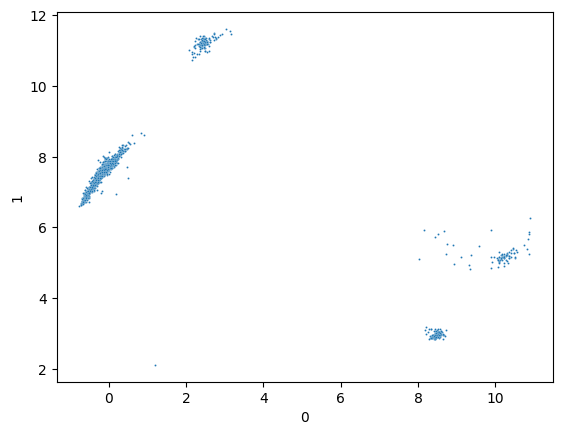

In [29]:
# plot the embeddings

sns.scatterplot(data=pd.DataFrame(predicted_embeddings), x=0, y=1, s=2);

In [724]:
# from filtered_df, remove genes appearing in less than 100 samples and samples with less than 10 genes
asdf = filtered_df.loc[:, filtered_df.columns[filtered_df.sum() > 100]]

asdf.shape

(11175, 10455)

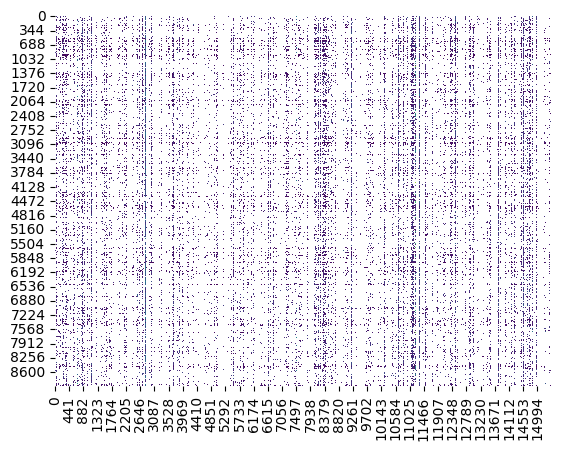

In [627]:
# plot the non-zero values in the data, each sample; x axis = samples, y axis = genes
non_zero_values = pd.DataFrame(X_train.numpy()).replace(masking_value, np.nan)
sns.heatmap(non_zero_values, cmap='viridis', cbar=False);

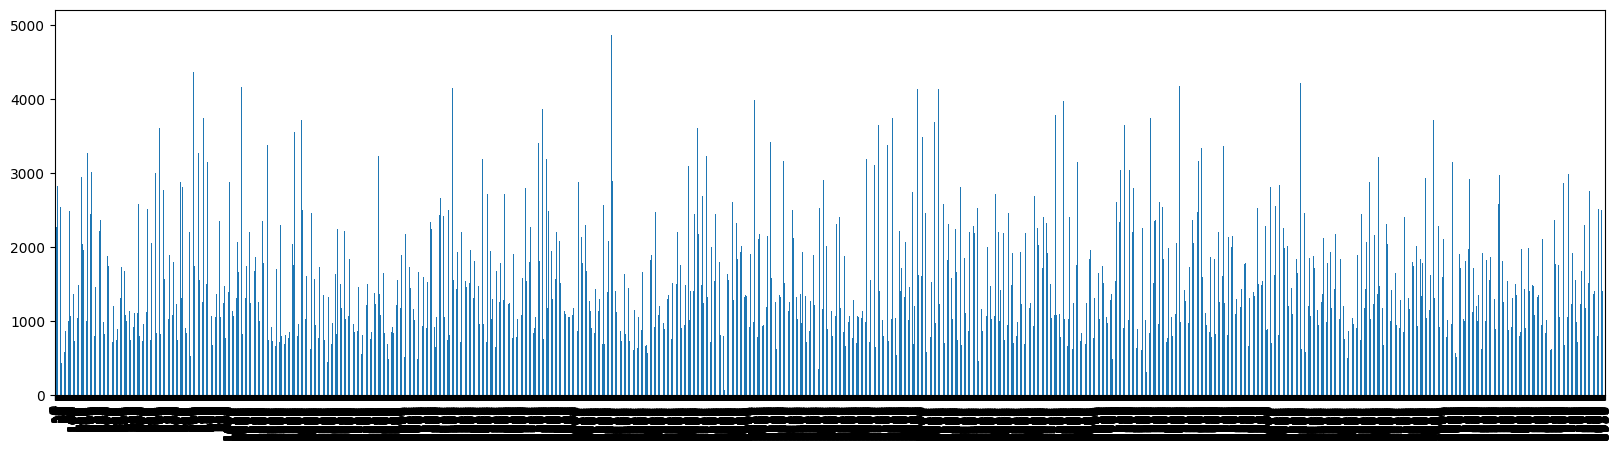

In [645]:
# now, draw a bar plot for each sample, showing the number of non-zero values, ordered decreasingly by the number of non-zero values
non_zero_values_count = non_zero_values.count(axis=1)
# non_zero_values_count = non_zero_values_count.sort_values(ascending=False)
non_zero_values_count.plot(kind='bar', figsize=(20, 5));
plt.title('Number of non-zero values in each sample');

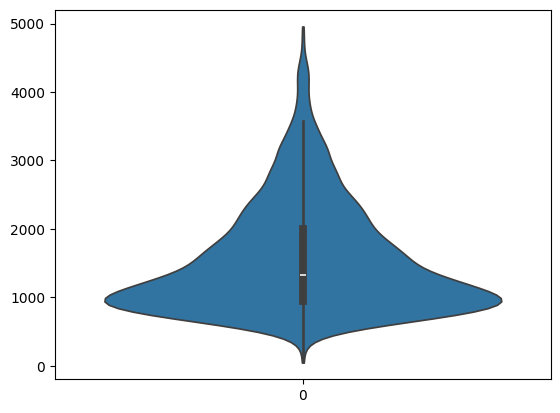

In [664]:
non_zero_values_count = non_zero_values.count(axis=1)
non_zero_values_count = non_zero_values_count
sns.violinplot(data=non_zero_values_count.to_frame(), cut=0);

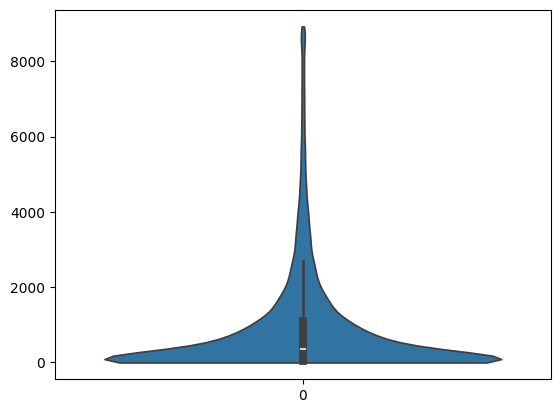

In [663]:
non_zero_values_count = non_zero_values.count(axis=0)
non_zero_values_count = non_zero_values_count
sns.violinplot(data=non_zero_values_count.to_frame(), cut=0);

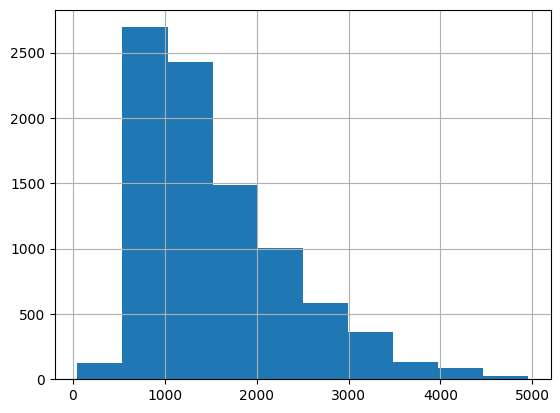

In [631]:
non_zero_values_count.hist();

In [1107]:
# Take the index of the selected gene from the filtered_df | EGLN2 == PHD1
gene_index = filtered_df.columns.get_loc('EGLN2')

# Select the first sample from the test set with non-zero expression of the selected gene
mask = X_test[:, gene_index] != masking_value
non_zero_samples = X_test[mask]
test_sample = non_zero_samples[4].reshape(1, -1).clone()

# Check the original expression of the gene
print('Original EGLN2 expression:', test_sample[0, gene_index])

# Check for the expression of glycolysis related genes
glycolysis_gene_index = filtered_df.columns.get_loc('PKM')

# Check the original expression of the gene
print('Original PKM expression:', test_sample[0, glycolysis_gene_index])

# Iteratively decrease the expression of EGLN2 with masked PKM and check the predicted expression of PKM
perturbed_sample = test_sample.clone()
perturbed_sample[0, glycolysis_gene_index] = 0
cell_states = []
predicted_expression = predict_gene_expression(perturbed_sample)
cell_states.append(predicted_expression)
while perturbed_sample[0, gene_index] >= 0.1:
    perturbed_sample[0, gene_index] = perturbed_sample[0, gene_index] - 0.1

    predicted_expression = predict_gene_expression(perturbed_sample)

    cell_states.append(predicted_expression)

cell_states = torch.cat(cell_states, dim=0)

Original EGLN2 expression: tensor(0.8017)
Original PKM expression: tensor(0.)


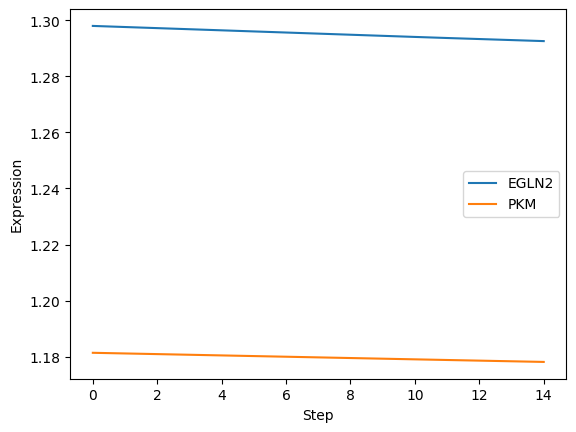

In [1102]:
# Plot how the expression of PKM changes with the decreasing expression of EGLN2 using two line plots
plt.plot(cell_states[:, gene_index], label='EGLN2')
plt.plot(cell_states[:, glycolysis_gene_index], label='PKM')
plt.xlabel('Step')
plt.ylabel('Expression')
plt.legend();

In [247]:
import sys  
sys.path.insert(1, '../src')

import pandas as pd
import torch
import torch.nn as nn

from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from Autoencoder import Autoencoder
from VirtualCellLine import VirtualCellLine
from utils import run_simulation


# Load the data
print('Loading data...')
data = pd.read_parquet('../data/filtered_expression_data.parquet')

X_train, X_test = train_test_split(data, test_size=0.2, random_state=23)

# Standardize the data
print('Standardizing the data...')
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

# Hyperparameters
input_size = X_test.shape[1]
embedding_dim = 128
num_heads = 8
num_transformer_layers = 6
layer_dims = [input_size, embedding_dim]
num_epochs = 1000
dropout_rate = 0
learning_rate = 0.0001
masking_value = 0
batch_size = 128
min_genes_to_mask = 0.5
max_genes_to_mask = 0.8

# Model
# model = Autoencoder(layer_dims, dropout_rate)
model = VirtualCellLine(input_size, embedding_dim=embedding_dim, num_heads=num_heads, num_transformer_layers=num_transformer_layers, dropout_rate=dropout_rate)

# Loss function
criterion = nn.MSELoss()

# Create data loaders
test_loader = DataLoader(TensorDataset(X_test), batch_size=batch_size, shuffle=False)

model.load_state_dict(torch.load('../autoencoder_20240727142008.pth'))
model.eval()

Loading data...
Standardizing the data...


/usr/local/anaconda3/envs/ibd/lib/python3.11/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


VirtualCellLine(
  (embedding): Linear(in_features=15421, out_features=128, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=15421, bias=True)
)

In [249]:
X = torch.cat([X_train, X_test], dim=0)

with torch.no_grad():
    predicted_expressions = model(X)
    predicted_expressions = predicted_expressions.detach().numpy()

In [250]:
import umap

reducer = umap.UMAP()
reducer = reducer.fit(predicted_expressions)
predicted_embeddings = reducer.transform(predicted_expressions)

In [269]:
import numpy as np

from datetime import datetime

# Select a random sample
np.random.seed(datetime.now().microsecond)
sample_id = np.random.randint(X_test.shape[0])
test_sample = X_test[sample_id].reshape(1, -1)

# Run it through the model to predict the expression of all genes
with torch.no_grad():
    predicted_sample = model(test_sample)

# Select a random gene
gene_index = np.random.randint(X_test.shape[1])
print('Gene name:', data.columns[gene_index])

# Check the original expression of the gene
original_expression = predicted_sample[0, gene_index].item()
print('Original gene expression:', original_expression)

# Perturb the gene expression. If the gene expression is below 0.5, set it to 0.8, otherwise set it to 0.2.
perturbation = 0.9 if original_expression < 0.5 else 0.1
print('Perturbation:', perturbation)

# Calculate the man of the perturbed samples
mean_sample = torch.mean(X_test, dim=0).reshape(1, -1)

# Simulate the perturbation
perturbed_sample = model.simulate(predicted_sample, [gene_index], [perturbation])
unperturbed_sample = model.simulate(predicted_sample, [], [])

# Print the top 10 genes with the highest absolute difference in expression
diff = torch.abs(perturbed_sample - unperturbed_sample)
ranking = diff.argsort(descending=True).squeeze().numpy()
print('Top 10 genes with the highest absolute difference in expression:')
for i in range(10):
    gene_name = data.columns[ranking[i]]
    print(f'{gene_name}: {diff[0, ranking[i]].item()}')

Gene name: ANO4
Original gene expression: 0.68385910987854
Perturbation: 0.1
Top 10 genes with the highest absolute difference in expression:
C11orf91: 0.00042426586151123047
CLEC18B: 0.00039589405059814453
BSCL2: 0.00036513805389404297
COL6A2: 0.00036394596099853516
DCHS1: 0.00035309791564941406
CD55: 0.0003522634506225586
DENND1C: 0.0003470480442047119
RAPGEF5: 0.00034296512603759766
CDKL4: 0.0003428459167480469
HMSD: 0.00034117698669433594


In [270]:
# embedd the perturbed cell states
start_embedding = reducer.transform(predicted_sample.numpy())
end_embedding = reducer.transform(perturbed_sample.numpy())
end_embedding_unperturbed = reducer.transform(unperturbed_sample.numpy())

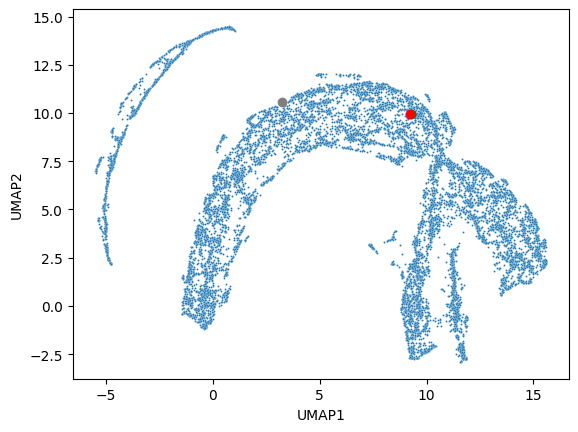

In [271]:
import seaborn as sns

# plot the embeddings
sns.scatterplot(data=pd.DataFrame(predicted_embeddings, columns=['UMAP1', 'UMAP2']), x='UMAP1', y='UMAP2', s=2);

# plot the start and end points of the perturbation
plt.scatter(start_embedding[0, 0], start_embedding[0, 1], color='gray', label='Start')
plt.scatter(end_embedding[0, 0], end_embedding[0, 1], color='green', label='End');
plt.scatter(end_embedding_unperturbed[0, 0], end_embedding_unperturbed[0, 1], color='red', label='End unperturbed');

In [265]:
# Compare the average loss of the model between two random batches of samples
with torch.no_grad():
    batch1 = X_test[np.random.choice(X_test.shape[0], 32)]
    batch2 = X_test[np.random.choice(X_test.shape[0], 32)]

    loss = criterion(batch1, batch2)

print('Loss between two random samples:', loss.item())

Loss between two random samples: 0.02572453022003174


In [157]:
scaler.inverse_transform(perturbed_sample.numpy())

array([[0.685268  , 0.94631475, 0.70649   , ..., 2.4557838 , 1.1085496 ,
        4.3468695 ]], dtype=float32)